<a href="https://colab.research.google.com/github/Tan-1008/SoC_RL/blob/main/Week2_SoC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digit Classifier using PyTorch
We will be creating 2 pipelines to classify images of free-hand digits into 10 classes (each digit).

1.   Using simple Neural Network on flattened image to classify digits
2.   Using a CNN framework to classify digits







# Loading and Preprocessing
Here, we load and process the MNIST dataset, making it usable in our model.

In [ ]:
#Importing all libraires
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to use cuda whenever gpu available

#hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 4
batch_size = 100
learning_rate = 0.001

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.59MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 66.2kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.09MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


# Fully Connected Neural Network
Here is the code for implementing a Neural Network consisting of 1 hidden layer using PyTorch.

Epoch [1/4], Step [200/600], Loss: 0.2145
Epoch [1/4], Step [400/600], Loss: 0.3585
Epoch [1/4], Step [600/600], Loss: 0.1639
Epoch [2/4], Step [200/600], Loss: 0.0914
Epoch [2/4], Step [400/600], Loss: 0.1114
Epoch [2/4], Step [600/600], Loss: 0.1334
Epoch [3/4], Step [200/600], Loss: 0.0542
Epoch [3/4], Step [400/600], Loss: 0.1233
Epoch [3/4], Step [600/600], Loss: 0.0779
Epoch [4/4], Step [200/600], Loss: 0.0757
Epoch [4/4], Step [400/600], Loss: 0.0640
Epoch [4/4], Step [600/600], Loss: 0.2535


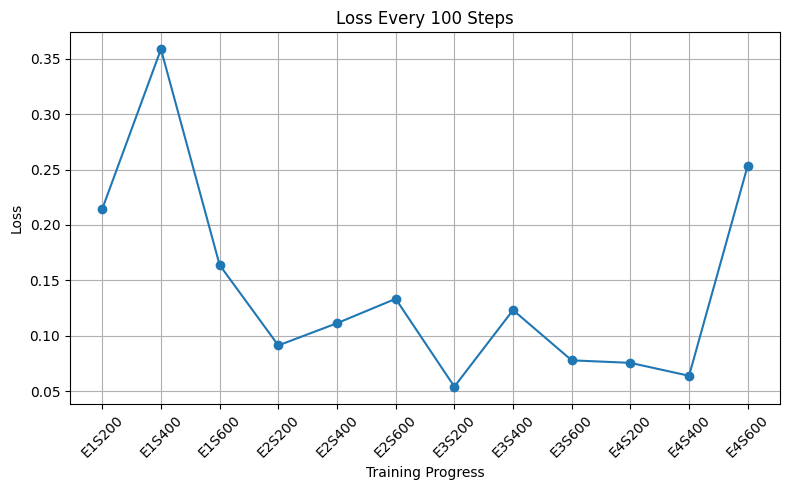

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        # no activation and no softmax at the end since we're using CrossEntropyLoss
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)   #using .to(device) to move it to GPU

# Loss and optimizer
criterion = nn.CrossEntropyLoss() #applies softmax activation on its own
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  #SGD was giving 2.2 loss and not improving much over many epochs

step_losses = []
step_labels = []
accuracy_list = []

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Store loss every 200 steps
        if (i + 1) % 200 == 0:
            step_losses.append(loss.item())
            step_labels.append(f'E{epoch+1}S{i+1}')
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

        # Accuracy on test set to generate plot
            with torch.no_grad():
                n_correct = 0
                n_samples = len(test_loader.dataset)
                for test_images, test_labels in test_loader:
                    test_images = test_images.reshape(-1, 28*28).to(device)
                    test_labels = test_labels.to(device)
                    test_outputs = model(test_images)
                    _, predicted = torch.max(test_outputs, 1)
                    n_correct += (predicted == test_labels).sum().item()
                acc = 100 * n_correct / n_samples
                accuracy_list.append(acc)


# Plotting Loss
plt.figure(figsize=(8, 5))
plt.plot(step_labels, step_losses, marker='o')
plt.xlabel('Training Progress')
plt.ylabel('Loss')
plt.title('Loss Every 100 Steps')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing our Neural Network
We will calculate the overall accuracy of our network on 1000 test images. In my training loop also, I have tested our neural network to be able to generate the graph for accuracy vs epochs, which let's us see how our neural network performs every 200 steps.

Accuracy of the network on the 10000 test images: 97.83 %


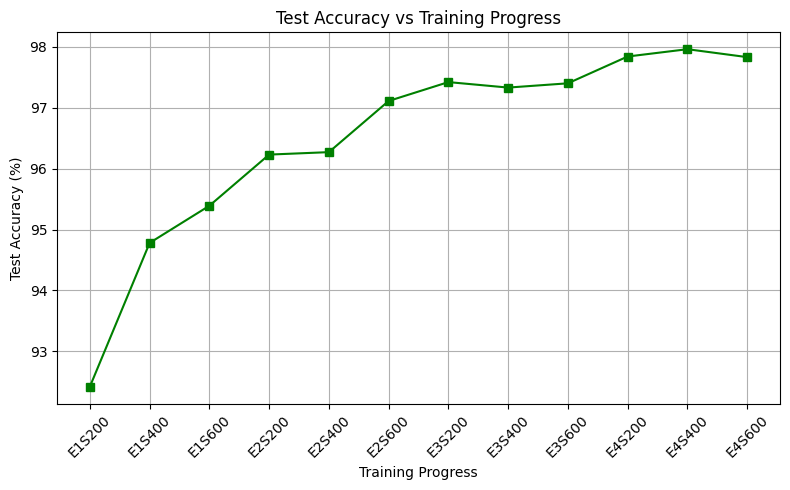

In [ ]:
with torch.no_grad():                                                           # since we dont need any gradients
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {100*acc} %')

# Accuracy plot from training loop
plt.figure(figsize=(8, 5))
plt.plot(step_labels, accuracy_list, marker='s', color='green')
plt.xlabel('Training Progress')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Training Progress')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Convolutional Neural Network
Now we will try to use a CNN framework in a similar manner to get even more accurate results.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Data Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Standard normalization for MNIST
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model = CNNModel().to(device)

# Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Training the dataset
Now we will train the dataset using our CNN model. We will keep number of epochs same as our first simple NN model so that we can compare the graphs to see which model performs better.

Epoch [1/2], Step [200], Loss: 0.4320
Epoch [1/2], Step [400], Loss: 0.1342
Epoch [1/2], Step [600], Loss: 0.0944
Epoch [1/2], Step [800], Loss: 0.0776
Epoch [2/2], Step [200], Loss: 0.0575
Epoch [2/2], Step [400], Loss: 0.0539
Epoch [2/2], Step [600], Loss: 0.0523
Epoch [2/2], Step [800], Loss: 0.0499


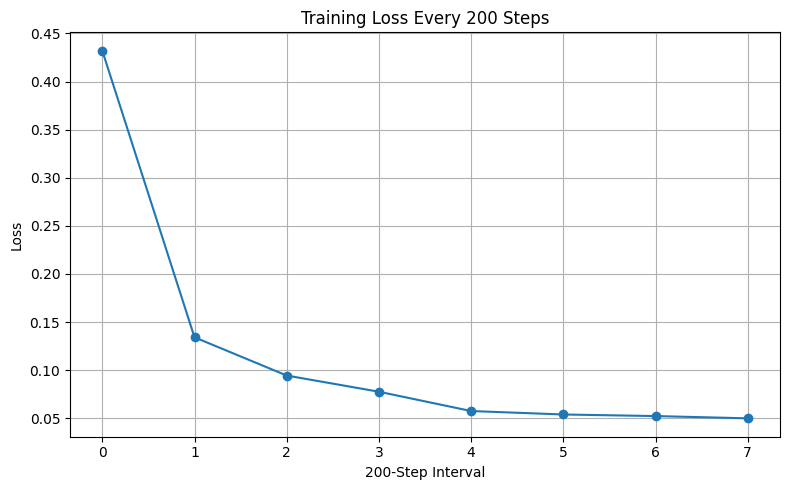

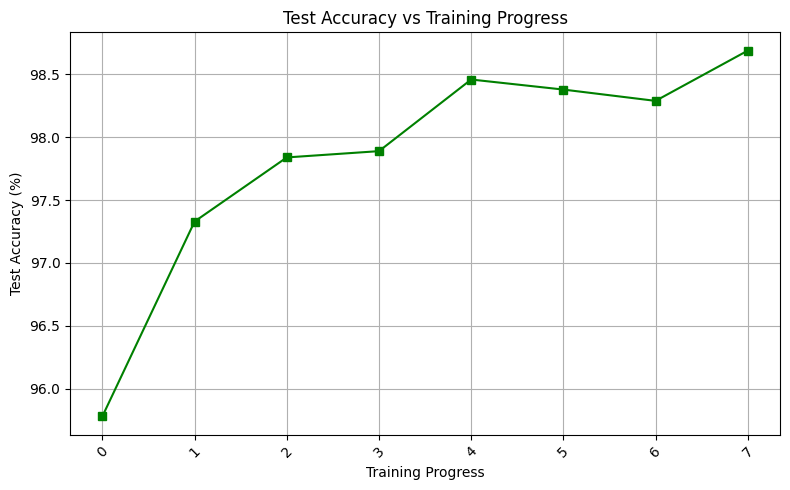

In [ ]:
epochs = 2                                                      # for some reason the accuracy of my model was peaking at the end of epoch 1, and then it was dipping back down below 99%, so i decided to keep only 1 epoch
step_losses = []
step_labels = []
accuracy_list = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for step, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Record every 200 steps
        if (step + 1) % 200 == 0:
            avg_loss = running_loss / 200
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step+1}], Loss: {avg_loss:.4f}")
            step_losses.append(avg_loss)
            running_loss = 0.0  # reset for next segment

        # Accuracy on test set to generate plot
            with torch.no_grad():
                n_correct = 0
                n_samples = len(test_loader.dataset)
                for test_images, test_labels in test_loader:
                    test_images = test_images.to(device)
                    test_labels = test_labels.to(device)
                    test_outputs = model(test_images)
                    _, predicted = torch.max(test_outputs, 1)
                    n_correct += (predicted == test_labels).sum().item()
                acc = 100 * n_correct / n_samples
                accuracy_list.append(acc)

# Plot intermediate losses
plt.figure(figsize=(8, 5))
plt.plot(step_losses, marker='o')
plt.title('Training Loss Every 200 Steps')
plt.xlabel('200-Step Interval')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

# Accuracy plot from training loop
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list, marker='s', color='green')
plt.xlabel('Training Progress')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy vs Training Progress')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing On Test Data
We will now test out our model on 1000 test images.

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():                                                           # since we dont need any gradients
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        # max returns (output_value ,index)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f'Accuracy of the network on the {n_samples} test images: {100*acc} %')

Accuracy of the network on the 10000 test images: 98.41 %


# Confusion Matrix
Below I have generated a confusion matrix using the heatmap function of seaborn library.

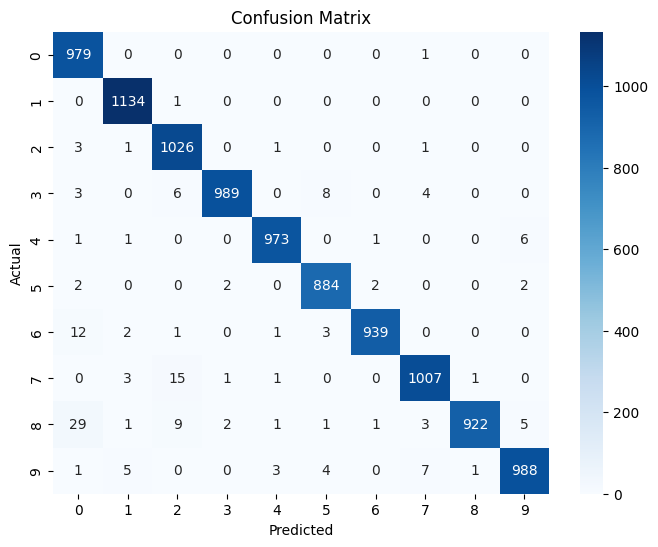

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()